In [1]:
import numpy as np

# 示例模型

In [2]:
N = 3
M = 4
T = 5

In [3]:
Obs = np.random.randint(0,M,T)

print(Obs)

[2 0 2 2 3]


In [4]:
EmitProb = np.random.random((N,M))
EmitProb /= np.array(EmitProb.sum(axis=1, keepdims=True))

print(EmitProb)
print(EmitProb.sum(axis=1))

[[0.25084167 0.09437353 0.44223858 0.21254621]
 [0.13789604 0.36494947 0.18763228 0.30952221]
 [0.18395687 0.16844457 0.38647533 0.26112324]]
[1. 1. 1.]


In [5]:
TransProb = np.random.random((N,N))
TransProb /= np.array([TransProb.sum(axis=-1)]).T

print(TransProb)
print(TransProb.sum(axis=1))

[[0.09003769 0.36328043 0.54668188]
 [0.42503939 0.33220671 0.2427539 ]
 [0.221876   0.27596732 0.50215667]]
[1. 1. 1.]


In [6]:
StartProb = np.random.random(N)
StartProb /= StartProb.sum()

print(StartProb)
print(StartProb.sum())

[0.14000889 0.1600101  0.69998101]
1.0


In [7]:
States = [i for i in range(N)]
Hmm = (Obs, States, StartProb, TransProb, EmitProb)

# Viterbi算法

In [8]:
def viterbi(obs, states, start_prob, trans_prob, emit_prob):
    P = np.zeros([len(obs), len(states)])
    path = np.zeros([len(states), len(obs)])

    for s in states:
        P[0][s] = start_prob[s] * emit_prob[s][obs[0]]
        path[s][0] = s

    for t in range(1, len(obs)):
        newpath = np.zeros([len(states), len(obs)])
        for s in states:
            prob = -1
            for s0 in states:
                nprob = P[t - 1][s0] * trans_prob[s0][s] * emit_prob[s][obs[t]]
                if nprob > prob:
                    prob = nprob
                    P[t][s] = prob
                    newpath[s][0:t] = path[s0][0:t]
                    newpath[s][t] = s
        path = newpath

    prob = -1
    state = 0
    for s in states:
        if P[len(obs)-1][s] > prob:
            prob = P[len(obs)-1][s]
            state = s

    print(P)

    return path[state]

print(viterbi(*Hmm))

[[6.19173317e-02 3.00230602e-02 2.70525393e-01]
 [1.50562931e-02 1.02947899e-02 2.49898286e-02]
 [2.45205519e-03 1.29398279e-03 4.84980517e-03]
 [4.75873210e-04 2.51124749e-04 9.41207346e-04]
 [4.43863078e-05 8.03960630e-05 1.23415602e-04]]
[2. 2. 2. 2. 2.]


# Baum-Welch算法

In [9]:
def forward(observations, states, start_prob, trans_prob, emit_prob):
    alpha = np.zeros([len(observations), len(states)])

    for s in states:
        alpha[0][s] = start_prob[s] * emit_prob[s][observations[0]]

    for t in range(1, len(observations)):
        for s in states:
            prob = 0
            for s0 in states:
                prob = prob + alpha[t-1][s0] * trans_prob[s0][s]
            alpha[t][s] = prob * emit_prob[s][observations[t]]

    return alpha, sum(alpha[len(observations)-1])

def backward(observations, states, start_prob, trans_prob, emit_prob):
    beta = np.zeros([len(observations), len(states)])

    for s in states:
        beta[len(observations)-1][s] = 1

    for i in range(1, len(observations)):
        for s in states:
            prob = 0
            for s0 in states:
                prob = prob + beta[len(observations)-i][s0] * trans_prob[s][s0] * emit_prob[s0][observations[len(observations)-i]]
            beta[len(observations)-i-1][s] = prob

    ob_prob = 0
    for s in states:
        ob_prob = ob_prob + start_prob[s] * emit_prob[s][observations[0]] * beta[0][s]

    return beta, ob_prob

def calc_gamma(alpha, beta, ob_prob):
    gamma = np.zeros(alpha.shape)
    for t in range(alpha.shape[0]):
        for i in range(alpha.shape[1]):
            gamma[t][i] = alpha[t][i]*beta[t][i]/ob_prob
    return gamma

def calc_ksi(alpha, beta, ob_prob, observations, trans_prob, emit_prob):
    ksi = np.zeros([alpha.shape[0]-1, alpha.shape[1], alpha.shape[1]])
    for t in range(alpha.shape[0]-1):
        for i in range(alpha.shape[1]):
            for j in range(alpha.shape[1]):
                ksi[t][i][j] = alpha[t][i]*trans_prob[i][j]*emit_prob[j][observations[t+1]]*beta[t+1][j]/ob_prob
    return ksi

def baum_welch(observations, states, start_prob, trans_prob, emit_prob):
    # 计算前向、反向矩阵
    alpha_array = []
    beta_array = []
    ob_prob_array = []
    for d in range(len(observations)):
        alpha, ob_prob = forward(observations[d], states, start_prob, trans_prob, emit_prob)
        alpha_array.append(alpha)
        ob_prob_array.append(ob_prob)
        beta, ob_prob = backward(observations[d], states, start_prob, trans_prob, emit_prob)
        beta_array.append(beta)

    # 验算
    '''print(ob_prob_array[0])
    test = 0
    for r in range(3):
        for s in range(3):
            test = test + alpha_array[0][0][r]*trans_prob[r][s]*emit_prob[s][observations[0][1]]*beta_array[0][1][s]
    print(test)'''

    # 计算状态占有率
    gamma_array = []
    for d in range(len(observations)):
        gamma = calc_gamma(alpha_array[d], beta_array[d], ob_prob_array[d])
        gamma_array.append(gamma)

    # 计算状态转移占有率
    ksi_array = []
    for d in range(len(observations)):
        ksi = calc_ksi(alpha_array[d], beta_array[d], ob_prob_array[d], observations[d], trans_prob, emit_prob)
        ksi_array.append(ksi)

    # 计算新的参数
    new_start_prob = np.zeros(start_prob.shape)
    for d in range(len(observations)):
        new_start_prob = new_start_prob + gamma_array[d][0]
    new_start_prob = new_start_prob / len(observations)

    new_trans_prob = np.zeros(trans_prob.shape)
    for i in range(trans_prob.shape[0]):
        for j in range(trans_prob.shape[1]):
            numerator = 0
            denominator = 0
            for d in range(len(observations)):
                for t in range(len(observations[d])-1):
                    numerator = numerator + ksi_array[d][t][i][j]
                    denominator = denominator + gamma_array[d][t][i]
            new_trans_prob[i][j] = numerator / denominator

    new_emit_prob = np.zeros(emit_prob.shape)
    for i in range(emit_prob.shape[0]):
        for j in range(emit_prob.shape[1]):
            numerator = 0
            denominator = 0
            for d in range(len(observations)):
                for t in range(len(observations[d])):
                    if observations[d][t] == j:
                        numerator = numerator + gamma_array[d][t][i]
                    denominator = denominator + gamma_array[d][t][i]
            new_emit_prob[i][j] = numerator / denominator

    return new_start_prob, new_trans_prob, new_emit_prob

In [10]:
for i in range(15):
    StartProb, TransProb, EmitProb = baum_welch([Obs], States, StartProb, TransProb, EmitProb)

StartProb, TransProb, EmitProb

(array([2.12747364e-16, 7.18292427e-36, 1.00000000e+00]),
 array([[1.01246102e-09, 2.00437245e-10, 9.99999999e-01],
        [9.99989673e-01, 6.54481431e-21, 1.03268746e-05],
        [9.42752789e-07, 9.99993821e-01, 5.23629329e-06]]),
 array([[9.48729476e-11, 0.00000000e+00, 9.99998115e-01, 1.88520151e-06],
        [5.00000508e-01, 0.00000000e+00, 1.46275899e-12, 4.99999492e-01],
        [3.93546468e-16, 0.00000000e+00, 9.99999927e-01, 7.34804330e-08]]))

In [11]:
Hmm = (Obs, States, StartProb, TransProb, EmitProb)
print(viterbi(*Hmm))

[[2.12746963e-16 1.05068870e-47 9.99999927e-01]
 [8.94417294e-17 4.99997382e-01 2.06072458e-21]
 [4.99991276e-01 4.78671791e-33 5.16340989e-06]
 [5.06220724e-10 7.55277756e-18 4.99991238e-01]
 [8.88623918e-13 2.49993820e-01 1.92379178e-13]]
[2. 1. 0. 2. 1.]


# 使用WFST表示HMM

In [12]:
import openfst_python as fst

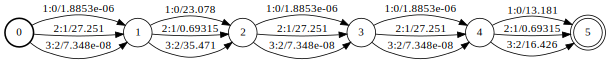

In [13]:
def obs_mat(obs, emit_prob, N, T):
    f = fst.Fst()
    st = []
    for t in range(T+1):
        st += [f.add_state()]
        
    for t in range(T):
        for j in range(N):
            f.add_arc(st[t], fst.Arc(j+1, j, fst.Weight(f.weight_type(), -np.log(emit_prob[j,obs[t]])), st[t+1]))
        
    f.set_start(st[0])
    f.set_final(st[T])
    return f

ObsFst = obs_mat(Obs, EmitProb, N, T)
ObsFst

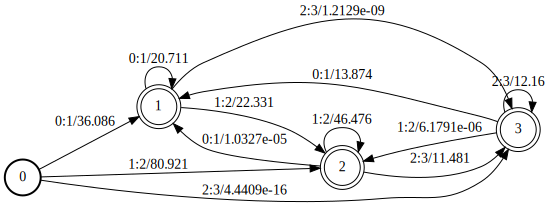

In [14]:
def trans_mat(start_prob, trans_prob, N):
    f = fst.Fst()
    st = []
    for i in range(N+1):
        st += [f.add_state()]
    
    for i in range(N):
        f.add_arc(st[0], fst.Arc(i, i+1, fst.Weight(f.weight_type(), -np.log(start_prob[i])), st[i+1]))
    
    for i in range(N):
        for j in range(N):
            f.add_arc(st[i+1], fst.Arc(j, j+1, fst.Weight(f.weight_type(), -np.log(trans_prob[i,j])), st[j+1]))

    f.set_start(st[0])
    for i in range(N):
        f.set_final(st[i+1])
    
    return f

TransFst = trans_mat(StartProb, TransProb, N)
TransFst

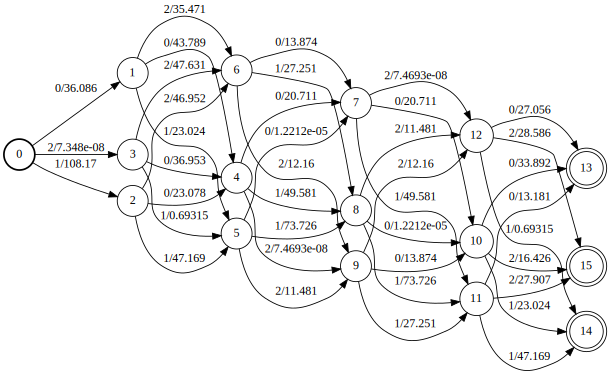

In [15]:
HmmFst = fst.compose(TransFst, ObsFst)
HmmFst

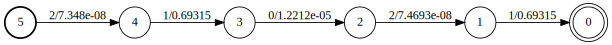

In [16]:
fst.shortestpath(HmmFst)